**Goal**: create a forecast of Madrid's electric demand

TODO: value counts na weather desc

In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timezone
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

# Preprocessing of data

In [28]:
energy_data = pd.read_csv('energy_dataset.csv')
weather_data = pd.read_csv('weather_features.csv')

energy_data.time = pd.to_datetime(energy_data.time).apply(lambda x: x.astimezone(timezone.utc))
energy_data = energy_data.set_index('time')

weather_data = weather_data[weather_data.city_name == 'Madrid'].copy()
weather_data.dt_iso = pd.to_datetime(weather_data.dt_iso).apply(lambda x: x.astimezone(timezone.utc))
weather_data = weather_data.set_index('dt_iso')
weather_data = weather_data.drop(colums='city_name')
weather_data = weather_data[~weather_data.index.duplicated()]
data = pd.merge(energy_data, weather_data, left_index=True, right_index=True)
data.index = pd.to_datetime(data.index.strftime("%Y-%m-%d %H:%M:%S"))

In [29]:
data.isnull().sum()[data.isnull().sum() > .1 * len(data)]

generation hydro pumped storage aggregated    35064
forecast wind offshore eday ahead             35064
dtype: int64

In [30]:
data.columns[data.any() == False]

Index(['generation fossil coal-derived gas', 'generation fossil oil shale',
       'generation fossil peat', 'generation geothermal',
       'generation hydro pumped storage aggregated', 'generation marine',
       'generation wind offshore', 'forecast wind offshore eday ahead'],
      dtype='object')

In [31]:
drop_cols_null = data.isnull().sum()[data.isnull().sum() > .1 * len(data)].index
drop_cols_zeros = data.columns[data.any() == False]
drop_cols = np.unique(np.concatenate((drop_cols_null, drop_cols_zeros)))
data = data.drop(columns=drop_cols)

In [32]:
data.isna().sum()[data.isna().sum() > 0]

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
dtype: int64

In [33]:
# splines of order 1
data = data.interpolate(method='slinear')

TODO: napisać ładniej

Demand for energy is not dependent on the source of generated energy, so we can create one columns in which there are summed up different generation sources.

In [34]:
generation_cols = data.columns[:14] 
data['total_generation'] = data[generation_cols].sum(axis=1)
data = data.drop(columns=generation_cols)
data = data[['total_generation'] + list(data.columns[:-1])]

Description of different columns:
datetime index localized to CET

city_name
name of city

temp
in k

temp_min
minimum in k

temp_max
maximum in k

pressure
pressure in hPa

humidity
humidity in %

wind_speed
wind speed in m/s

wind_deg
wind direction

rain_1h
rain in last hour in mm

rain_3h
rain last 3 hours in mm

snow_3h
show last 3 hours in mm

clouds_all
cloud cover in %

weather_id
Code used to describe weather

weather_main
Short description of current weather

weather_description
Long description of current weather

weather_icon
Weather icon code for website


In [35]:
data.weather_description.value_counts()

sky is clear                    20352
few clouds                       4208
scattered clouds                 3054
broken clouds                    2888
light rain                       1356
mist                              615
moderate rain                     592
overcast clouds                   493
fog                               466
light intensity drizzle           299
proximity shower rain             182
light intensity shower rain       118
proximity thunderstorm            101
drizzle                            82
shower rain                        77
thunderstorm                       51
heavy intensity rain               47
haze                               16
light snow                         16
snow                               13
heavy intensity shower rain         9
thunderstorm with rain              7
light rain and snow                 7
thunderstorm with light rain        4
rain and snow                       2
sleet                               2
heavy intens

In [36]:
data = data.drop(columns=['weather_id', 'weather_main', 'weather_icon', 'weather_description'])

Now we have to take care of categorical variables.

In [37]:
pd.options.display.max_rows = 100

In [38]:
len(data.iloc[:, -1:].value_counts())

88

In [39]:
data.dtypes

total_generation                   float64
forecast solar day ahead           float64
forecast wind onshore day ahead    float64
total load forecast                float64
total load actual                  float64
price day ahead                    float64
price actual                       float64
temp                               float64
temp_min                           float64
temp_max                           float64
pressure                             int64
humidity                             int64
wind_speed                           int64
wind_deg                             int64
rain_1h                            float64
rain_3h                            float64
snow_3h                            float64
clouds_all                           int64
dtype: object

We can use one-hot encoding, but 32 additional columns are too much

In [40]:
data

total_generation  forecast solar day ahead  \
time                                                              
2014-12-31 23:00:00           28251.0                      17.0   
2015-01-01 00:00:00           27818.0                      16.0   
2015-01-01 01:00:00           26796.0                       8.0   
2015-01-01 02:00:00           25223.0                       2.0   
2015-01-01 03:00:00           24620.0                       9.0   
...                               ...                       ...   
2018-12-31 18:00:00           26415.0                      96.0   
2018-12-31 19:00:00           25213.0                      51.0   
2018-12-31 20:00:00           23987.0                      36.0   
2018-12-31 21:00:00           22748.0                      29.0   
2018-12-31 22:00:00           22605.0                      26.0   

                     forecast wind onshore day ahead  total load forecast  \
time                                                                        
2014-12-31 23:00:00                           6436.0              26118.0   
2015-01-01 00:00:00                           5856.0              24934.0   
2015-01-01 01:00:00                           5454.0              23515.0   
2015-01-01 02:00:00                           5151.0              22642.0   
2015-01-01 03:00:00                           4861.0              21785.0   
...                                              ...                  ...   
2018-12-31 18:00:00                           3253.0              30619.0   
2018-12-31 19:00:00                           3353.0              29932.0   
2018-12-31 20:00:00                           3404.0              27903.0   
2018-12-31 21:00:00                           3273.0              25450.0   
2018-12-31 22:00:00                           3117.0              24424.0   

                     total load actual  price day ahead  price actual  \
time                                                                    
2014-12-31 23:00:00            25385.0            50.10         65.41   
2015-01-01 00:00:00            24382.0            48.10         64.92   
2015-01-01 01:00:00            22734.0            47.33         64.48   
2015-01-01 02:00:00            21286.0            42.27         59.32   
2015-01-01 03:00:00            20264.0            38.41         56.04   
...                                ...              ...           ...   
2018-12-31 18:00:00            30653.0            68.85         77.02   
2018-12-31 19:00:00            29735.0            68.40         76.16   
2018-12-31 20:00:00            28071.0            66.88         74.30   
2018-12-31 21:00:00            25801.0            63.93         69.89   
2018-12-31 22:00:00            24455.0            64.27         69.88   

                        temp  temp_min  temp_max  pressure  humidity  \
time                                                                   
2014-12-31 23:00:00  267.325   267.325   267.325       971        63   
2015-01-01 00:00:00  267.325   267.325   267.325       971        63   
2015-01-01 01:00:00  266.186   266.186   266.186       971        64   
2015-01-01 02:00:00  266.186   266.186   266.186       971        64   
2015-01-01 03:00:00  266.186   266.186   266.186       971        64   
...                      ...       ...       ...       ...       ...   
2018-12-31 18:00:00  283.560   282.150   285.150      1030        88   
2018-12-31 19:00:00  280.120   278.150   281.150      1031        52   
2018-12-31 20:00:00  278.150   278.150   278.150      1030        65   
2018-12-31 21:00:00  276.570   276.150   277.150      1031        69   
2018-12-31 22:00:00  275.150   275.150   275.150      1031        74   

                     wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  \
time                                                                   
2014-12-31 23:00:00           1       309      0.0      0.0      0.0   
2015-01-01 00:00:00           1       309   

### Outliers

In [ ]:
data.describe()

total_generation  forecast solar day ahead  \
count      35064.000000              35064.000000   
mean       28639.080453               1439.066735   
std         4186.310196               1677.703355   
min         6899.000000                  0.000000   
25%        25448.000000                 69.000000   
50%        28456.000000                576.000000   
75%        31571.000000               2636.000000   
max        42310.000000               5836.000000   

       forecast wind onshore day ahead  total load forecast  \
count                     35064.000000         35064.000000   
mean                       5471.216689         28712.129962   
std                        3176.312853          4594.100854   
min                         237.000000         18105.000000   
25%                        2979.000000         24793.750000   
50%                        4855.000000         28906.000000   
75%                        7353.000000         32263.250000   
max                       17430.000000         41390.000000   

       total load actual  price day ahead  price actual          temp  \
count       35064.000000     35064.000000  35064.000000  35064.000000   
mean        28698.281385        49.874341     57.884023    288.277131   
std          4575.828854        14.618900     14.204083      9.326993   
min         18041.000000         2.060000      9.330000    264.132000   
25%         24807.000000        41.490000     49.347500    281.150000   
50%         28902.000000        50.520000     58.020000    286.930000   
75%         32194.250000        60.530000     68.010000    294.950000   
max         41015.000000       101.990000    116.800000    313.330000   

           temp_min      temp_max      pressure      humidity    wind_speed  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean     287.051835    289.371963   1011.781115     58.725331      2.433807   
std        9.178753      9.681940     20.239961     24.883323      1.973041   
min      264.132000    264.132000    927.000000      0.000000      0.000000   
25%      280.150000    282.150000   1013.000000     38.000000      1.000000   
50%      286.140000    288.150000   1017.000000     59.000000      2.000000   
75%      293.710000    296.150000   1022.000000     81.000000      3.000000   
max      312.150000    316.480000   1042.000000    100.000000     18.000000   

           wind_deg       rain_1h       rain_3h       snow_3h    clouds_all  
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000  
mean     173.363906      0.043301      0.000133      0.000030     20.661334  
std      121.945440      0.198318      0.002591      0.005602     29.656482  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%       50.000000      0.000000      0.000000      0.000000      0.000000  
50%      190.000000      0.000000      0.000000      0.000000      0.000000  
75%      270.000000      0.000000      0.000000      0.000000     40.000000  
max      360.000000      3.000000      0.100000      1.049000    100.000000

In [53]:
len(data.columns)

18

In [97]:
data.pressure[data.pressure < 970]

time
2015-01-05 02:00:00    969
2015-01-05 03:00:00    969
2015-01-05 04:00:00    969
2015-01-05 05:00:00    969
2015-01-05 06:00:00    969
                      ... 
2018-11-19 16:00:00    943
2018-11-26 14:00:00    958
2018-11-26 15:00:00    958
2018-11-26 16:00:00    958
2018-11-26 17:00:00    960
Name: pressure, Length: 3456, dtype: int64

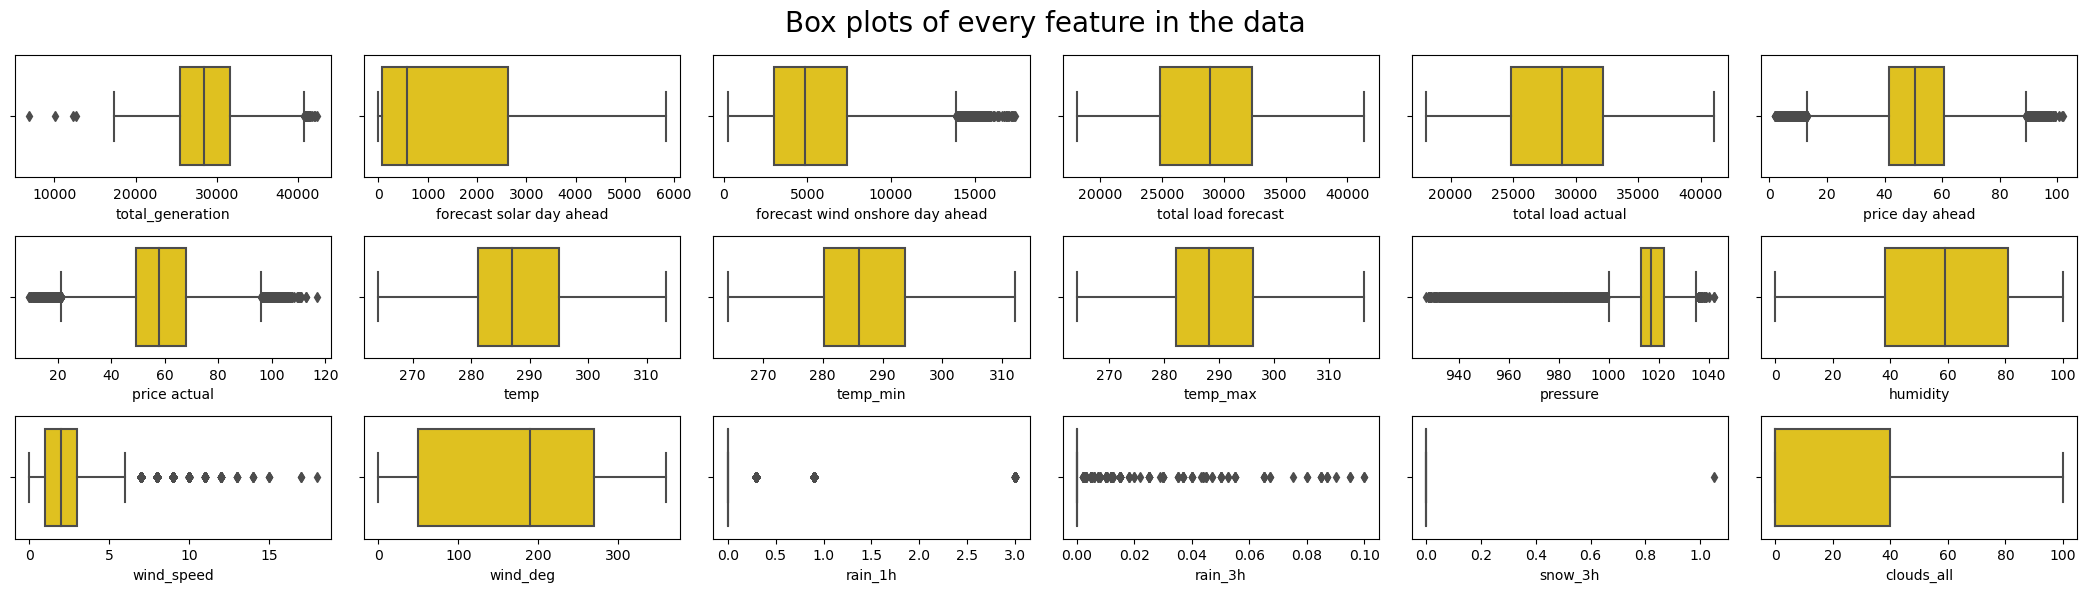

In [103]:
fig, axes = plt.subplots(3, 6, figsize=(21, 6), squeeze=True)
fig.suptitle('Box plots of every feature in the data', size=20)
cols = data.columns
for i in range(3):
    for j in range(6):
        sns.boxplot(ax=axes[i][j], data=data, x=cols[i * 6 + j], color='gold')
plt.tight_layout()
plt.show()

# Data Visualization

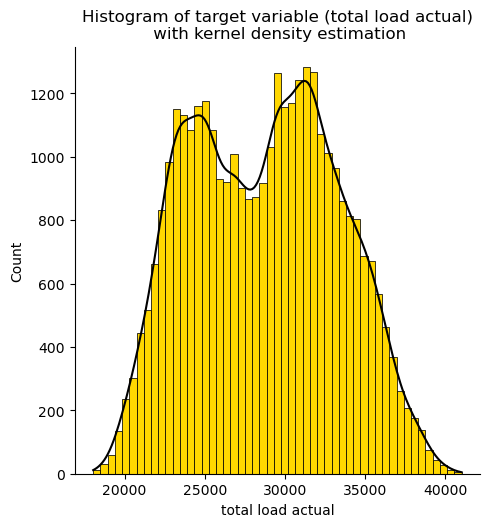

In [41]:
sns.displot(data['total load actual'], kde=True, color='black', facecolor='gold')
plt.title('Histogram of target variable (total load actual)\n with kernel density estimation')
plt.show()

Bimodal distribution

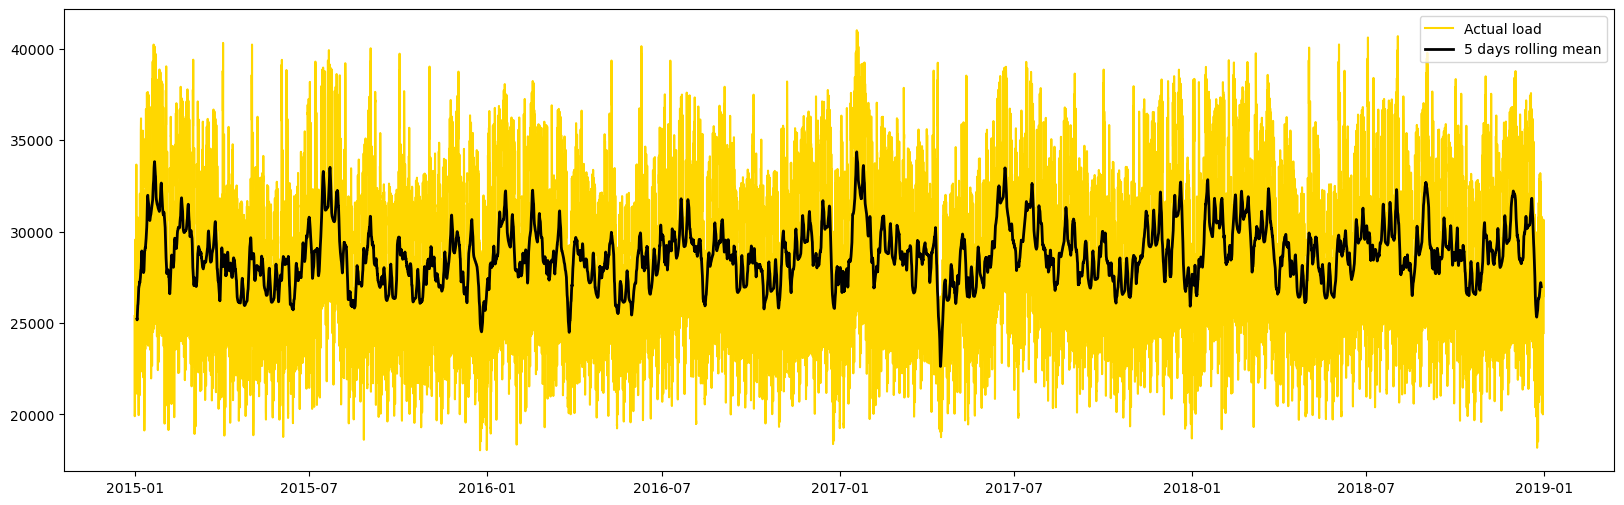

In [42]:
rolling = data['total load actual'].rolling(24*5, center = True).mean()
plt.figure(figsize=(20, 6))
plt.plot(data['total load actual'], color='gold', label='Actual load')
plt.plot(rolling, color = 'black', linestyle='-', linewidth=2, label='5 days rolling mean')
plt.legend()
plt.show()

In [43]:
X_cols = data.columns[:6].tolist() + data.columns[7:].tolist()
y_col = 'price actual'

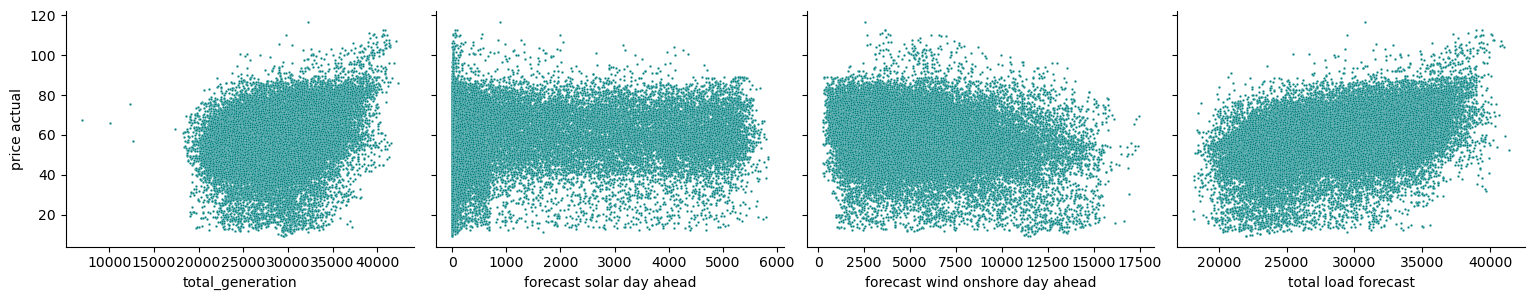

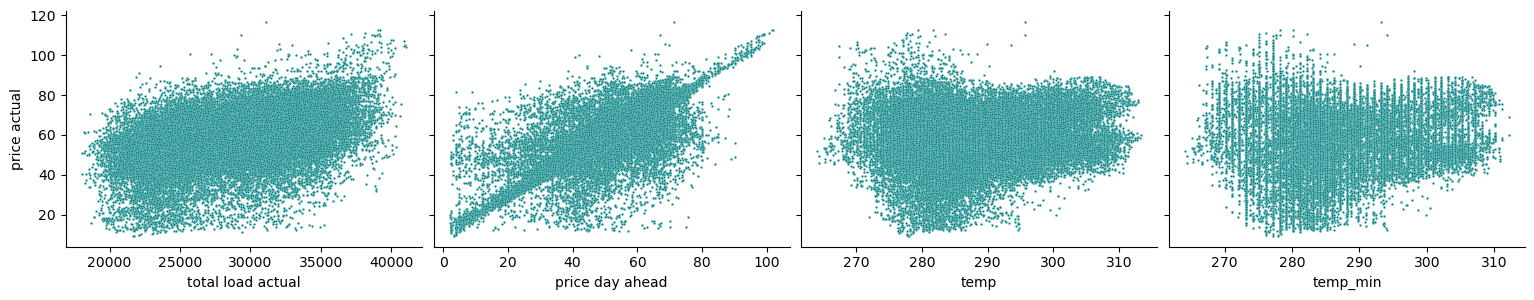

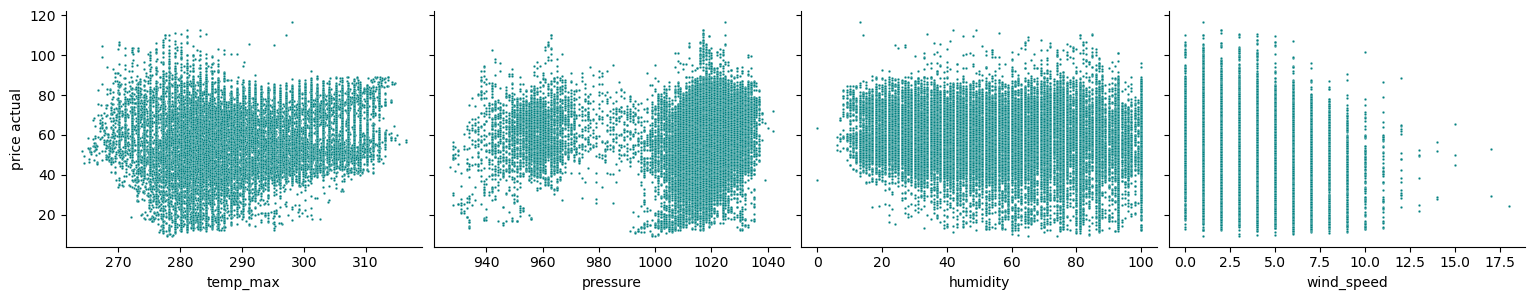

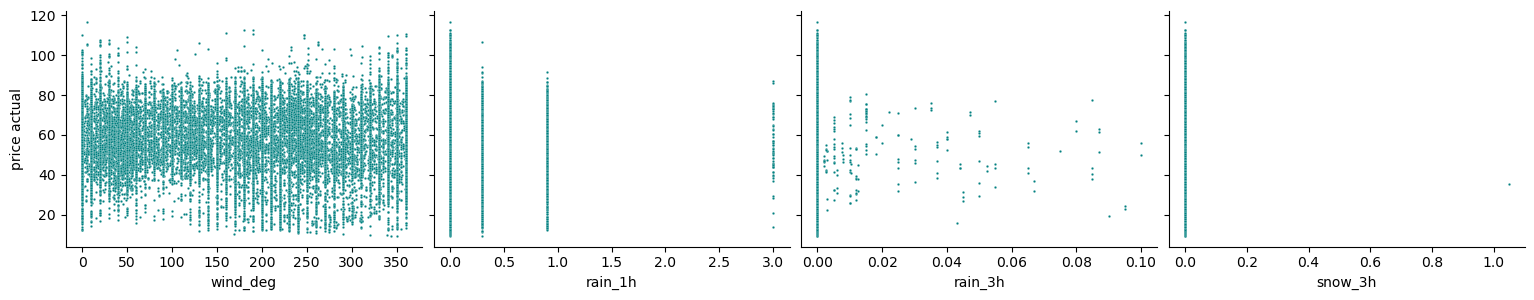

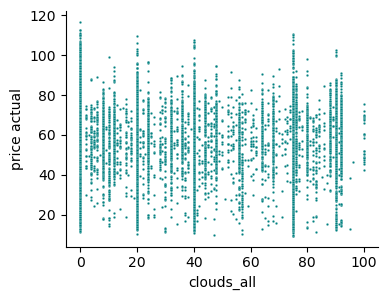

In [99]:
for i in range(5):
    aaa = sns.pairplot(data = data, x_vars=X_cols[4*i: 4*(i+1)], y_vars=y_col, height=3, aspect=1.3,  plot_kws={'s': 3, 'color': 'teal'})
    plt.show()

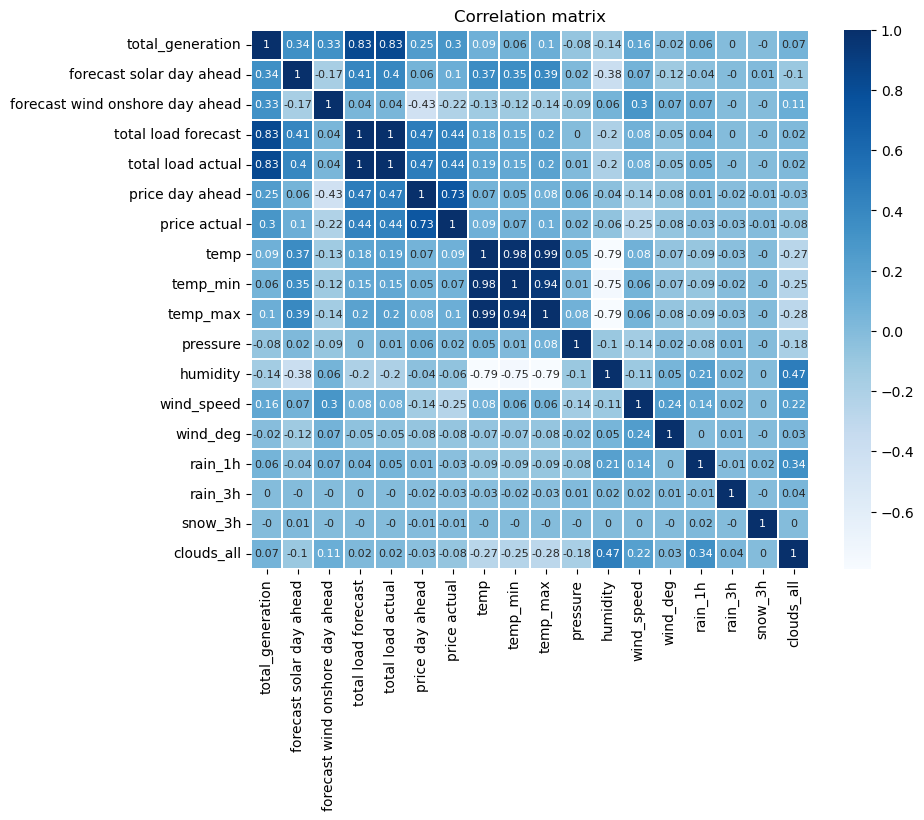

In [45]:
plt.figure(figsize=(9, 7))
sns.heatmap(round(data.corr(), 2), annot=True, cmap='Blues', linewidth=0.1, annot_kws={'fontsize': 8})
plt.title('Correlation matrix')
plt.show()

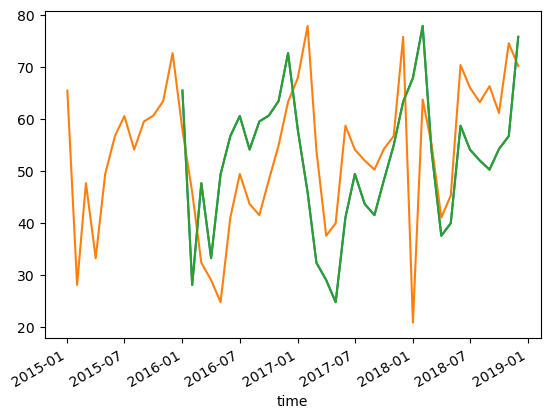

In [46]:
monthly_price = data['price actual'].asfreq('M')
lagged = monthly_price.shift(12).dropna()
fig, ax = plt.subplots(1,1)
lagged.plot()
ax.plot(monthly_price, label = 'Monthly Price')
ax.plot(lagged, label ='1 yr lagged')
plt.show()

In [47]:
data

total_generation  forecast solar day ahead  \
time                                                              
2014-12-31 23:00:00           28251.0                      17.0   
2015-01-01 00:00:00           27818.0                      16.0   
2015-01-01 01:00:00           26796.0                       8.0   
2015-01-01 02:00:00           25223.0                       2.0   
2015-01-01 03:00:00           24620.0                       9.0   
...                               ...                       ...   
2018-12-31 18:00:00           26415.0                      96.0   
2018-12-31 19:00:00           25213.0                      51.0   
2018-12-31 20:00:00           23987.0                      36.0   
2018-12-31 21:00:00           22748.0                      29.0   
2018-12-31 22:00:00           22605.0                      26.0   

                     forecast wind onshore day ahead  total load forecast  \
time                                                                        
2014-12-31 23:00:00                           6436.0              26118.0   
2015-01-01 00:00:00                           5856.0              24934.0   
2015-01-01 01:00:00                           5454.0              23515.0   
2015-01-01 02:00:00                           5151.0              22642.0   
2015-01-01 03:00:00                           4861.0              21785.0   
...                                              ...                  ...   
2018-12-31 18:00:00                           3253.0              30619.0   
2018-12-31 19:00:00                           3353.0              29932.0   
2018-12-31 20:00:00                           3404.0              27903.0   
2018-12-31 21:00:00                           3273.0              25450.0   
2018-12-31 22:00:00                           3117.0              24424.0   

                     total load actual  price day ahead  price actual  \
time                                                                    
2014-12-31 23:00:00            25385.0            50.10         65.41   
2015-01-01 00:00:00            24382.0            48.10         64.92   
2015-01-01 01:00:00            22734.0            47.33         64.48   
2015-01-01 02:00:00            21286.0            42.27         59.32   
2015-01-01 03:00:00            20264.0            38.41         56.04   
...                                ...              ...           ...   
2018-12-31 18:00:00            30653.0            68.85         77.02   
2018-12-31 19:00:00            29735.0            68.40         76.16   
2018-12-31 20:00:00            28071.0            66.88         74.30   
2018-12-31 21:00:00            25801.0            63.93         69.89   
2018-12-31 22:00:00            24455.0            64.27         69.88   

                        temp  temp_min  temp_max  pressure  humidity  \
time                                                                   
2014-12-31 23:00:00  267.325   267.325   267.325       971        63   
2015-01-01 00:00:00  267.325   267.325   267.325       971        63   
2015-01-01 01:00:00  266.186   266.186   266.186       971        64   
2015-01-01 02:00:00  266.186   266.186   266.186       971        64   
2015-01-01 03:00:00  266.186   266.186   266.186       971        64   
...                      ...       ...       ...       ...       ...   
2018-12-31 18:00:00  283.560   282.150   285.150      1030        88   
2018-12-31 19:00:00  280.120   278.150   281.150      1031        52   
2018-12-31 20:00:00  278.150   278.150   278.150      1030        65   
2018-12-31 21:00:00  276.570   276.150   277.150      1031        69   
2018-12-31 22:00:00  275.150   275.150   275.150      1031        74   

                     wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  \
time                                                                   
2014-12-31 23:00:00           1       309      0.0      0.0      0.0   
2015-01-01 00:00:00           1       309   

## Outliers detection

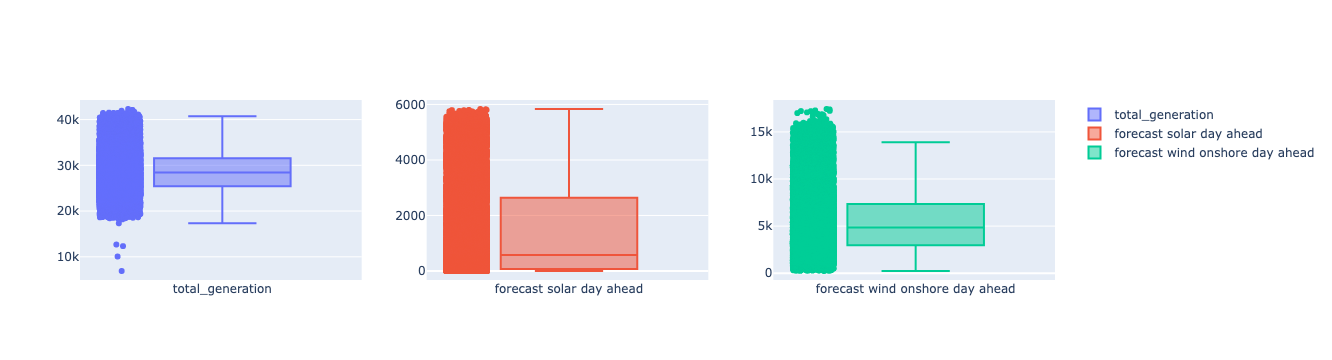

In [49]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
vars = list(data.columns)[:3]
fig = make_subplots(rows=1, cols=len(vars))
for i, var in enumerate(vars):
    fig.add_trace(
        go.Box(y=data[var],
        name=var),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

## Detection of seasonality

In [109]:
target = data[y_col]

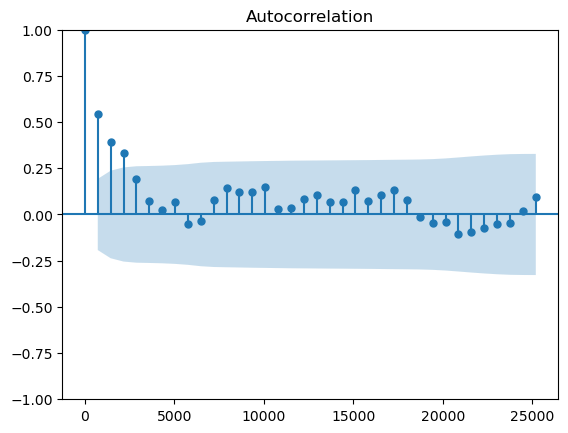

In [122]:
plot_acf(target, lags=[24*30*i for i in range(36)])
plt.show()

# Applying Machine Learning algorithms

In [129]:
x_cols = list(set(data.columns).difference({'total load actual'}))

In [131]:
X = data[x_cols]
y = data['total load actual']

We are dealing with time series, so we shouldn't shuffle the data during splitting for train and test sets (we have to maintain continuity of data). Thus, we will use `TimeSeriesSplit` object from sklearn.

## XGBoost

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.1)

In [198]:
model = xgb.XGBRegressor()

In [199]:
data_split = TimeSeriesSplit()

Parameters are chosen empirically.

In [206]:
parameters = {
    'max_depth': [2, 4, 6, 10],
    'n_estimators': [50, 75, 100, 200],
    'learning_rate': [0.2, 0.1, 0.01]
}

In [207]:
gsearch = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=data_split)
gsearch.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel

In [211]:
abs(gsearch.best_score_)

464.7841021378097